# Harry Potter Image Classification

As an exercise, I decided to try fast.ai's image classification algorithms on a new dataset: images of 10 Harry Potter characters. I used [this](https://github.com/hardikvasa/google-images-download) python script to automatically download images from google. Even though it can only download 100 images per keyword (without additional installations), it is still quite a handy tool.

The benefit of using google images is that it gives you images on any arbitrary topic. The downside is that also contains totally random pictures along with the ones you search for. You can either sort through them manually - which takes time - or you can train your algorithm on the partially corrupted data and hope that the algorithm learns to ignore the occasional mistaken image. I decided to do the latter and it worked quite well on this dataset.

So I downloaded 100 images for the 10 most common Harry Potter characters. Some pictures were corrupted and couldn't be opened, I automatically deleted those. Altogether, this resulted in a dataset with somewhat less than 1000 examples, spread through 10 classes to be predicted. 20% of this data was used as a validation set.

I fit a pretrained image model (resnet34), added data augmentations, used learning rate annealing, and got an accuracy of aroudn XXX%. After test time augmentation, that jumped to XXX%. These were mistaken measures though, as many of the validation images were falling in two categories: either not depicting the character in question, or showing multiple characters at once. Of course, these are not mistakes in the learning algorithm. Excluding these 'misclassifications', the model's accuracy jumped to XXX%. Not bad for only 1000 images and 10 classes!

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import random
import os

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

assert torch.cuda.is_available() & torch.backends.cudnn.enabled

PATH = "data/harry_potter/"
PATH_TRAIN = PATH+'train/'
DOWNLOAD_FLAG = False  # Select false if we have already donwloaded the images + labels

if not os.path.exists(PATH_TRAIN):
    os.makedirs(PATH_TRAIN)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
if DOWNLOAD_FLAG:
    
    import download_img_list
    
    characters = ['Harry Potter', 'Lord Voldemort', 'Hermione Granger', 'Severus Snape',
                 'Albus Dumbledore', 'Draco Malfoy', 'Dobby the House Elf', 'Ron Weasley',
                 'Hagrid', 'Sirius Black']
        
    labels, err_list = download_img_list.download_img_list(characters, PATH_TRAIN, 100)
        
    labels.to_csv(PATH+'labels.csv', index = False)
    
    print('\nNot download: ')
    print(err_list)
else:
    labels = pd.read_csv(PATH+'labels.csv')

## Look at the downloaded Images

In [3]:
def showPics(name, labels = labels, dims = (1, 5), directory = PATH_TRAIN):
    '''Show images of a given president'''
    nrows, ncols = dims
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize =(ncols * 4, nrows * 4))
    fns = list(labels['id'][labels['label'] == name])
    k = 0
    for i in range(nrows):
        for j in range(ncols):            
            if nrows > 1:
                axes[i, j].imshow(plt.imread(directory+fns[k]), cmap = 'gray')
                axes[i, j].set_title(fns[k])
            else:
                axes[j].imshow(plt.imread(directory+fns[k]), cmap = 'gray')
                axes[j].set_title(fns[k])
            k = (k + 1) % (len(fns))

For example, here are five images of Hagrid. The second also features Karl Marx, the 5th has nothing to do with Hagrid.

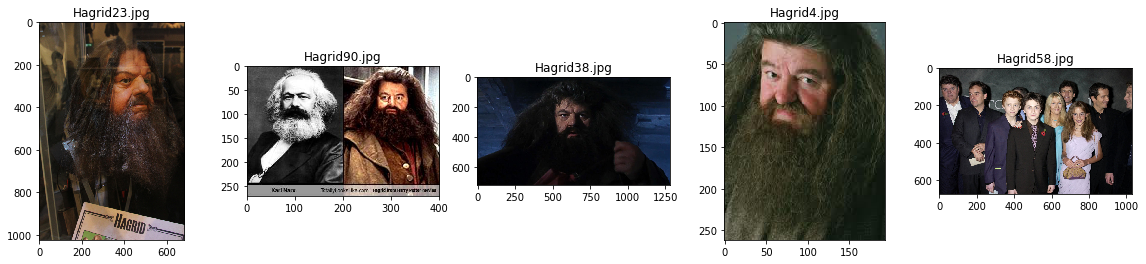

In [4]:
showPics('Hagrid')

In [5]:
labels.groupby('label').size().sort_values()

label
Harry_Potter           90
Severus_Snape          92
Sirius_Black           93
Hagrid                 95
Hermione_Granger       95
Lord_Voldemort         96
Albus_Dumbledore       97
Draco_Malfoy           97
Ron_Weasley            97
Dobby_the_House_Elf    99
dtype: int64

## Initial Model

In [6]:
n = len(labels.index)
val_idxs = get_cv_idxs(n, seed = 101)
(n, len(val_idxs))

(951, 190)

In [7]:
def get_data(sz, bs = 32): # sz: image size, bs: batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.2)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', val_idxs=val_idxs, 
                                        suffix='', tfms=tfms, bs=bs)
    return data if sz > 300 else data.resize(340, 'tmp')

In [8]:
sz = 224
arch = resnet34
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, precompute=True)  # Start with precompute = True

In [9]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                
    0      7.322829   1263.71336 0.289474  



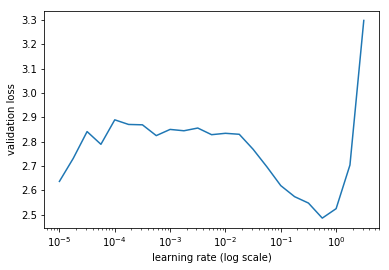

In [10]:
learn.sched.plot(0, 0)

In [11]:
lr = 1e-1

In [12]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy               
    0      2.114875   1.99081    0.631579  
    1      1.957375   1.858611   0.673684                



[array([1.85861]), 0.6736842092714812]

In [13]:
learn.precompute = False

In [14]:
learn.fit(lr, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.598972   1.410693   0.663158  
    1      1.43025    1.315846   0.668421                 



[array([1.31585]), 0.6684210557686655]

In [15]:
learn.save('hp_v1')

## Increase Image size

In [16]:
#learn.load('hp_v1')

In [17]:
sz = 299

In [18]:
learn.set_data(get_data(sz))

In [19]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.179615   1.123818   0.7       
    1      1.171546   1.12615    0.715789                 
    2      0.993882   1.04165    0.736842                  



[array([1.04165]), 0.7368421040083233]

In [20]:
learn.save('hp_v2')

## Unfreeze Layers

In [21]:
#learn.load('hp_v2')

In [22]:
learn.unfreeze()

 96%|█████████▌| 23/24 [00:10<00:00,  2.15it/s, loss=3.03] 

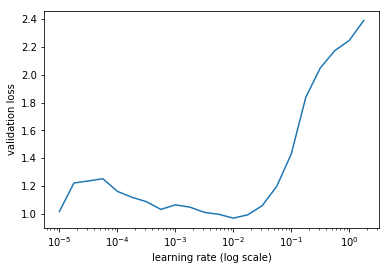

In [23]:
learn.lr_find()
learn.sched.plot(0, 0)

I'll assume that the beginning of this graph is simply due to random volatility. Still, I'll set a low learning rate, and train for only 1 cycle.

In [24]:
lr = 1e-2/2
lrs = [lr/100, lr/10, lr]
lrs

[5e-05, 0.0005, 0.005]

In [25]:
learn.fit(lrs, 1, cycle_len = 5)

epoch      trn_loss   val_loss   accuracy                 
    0      1.070325   0.919543   0.757895  
    1      0.882374   0.890763   0.768421                  
    2      0.799392   0.873331   0.768421                  
    3      0.708437   0.842542   0.773684                  
    4      0.62373    0.843961   0.778947                  


[array([0.84396]), 0.778947367166218]

In [26]:
learn.save('hp_v3')

Looks like we have an accuracy of about 77% and we're starting to over-fit; I'll stop training here.

## Include TTA

In [27]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
preds = np.argmax(probs, 1)

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

cm

array([[13,  0,  1,  1,  1,  0,  0,  1,  0,  0],
       [ 0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 18,  0,  0,  0,  0,  0,  2,  0],
       [ 1,  0,  0, 18,  1,  0,  0,  1,  1,  1],
       [ 1,  0,  0,  0,  9,  0,  2,  3,  0,  0],
       [ 0,  0,  0,  0,  0, 16,  0,  2,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 27,  0,  1,  2],
       [ 0,  1,  1,  0,  2,  1,  0, 13,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0, 15,  0],
       [ 0,  0,  0,  1,  3,  0,  0,  1,  0, 12]])

In [29]:
num_correct = (cm * np.eye(len(data.classes))).sum()
acc = num_correct / cm.sum()
acc

0.8210526315789474

TTA brings accuracy up to 82%. Not too bad.

## Look at Misclassified Images

In [30]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, main_title = None, titles=None):
    f = plt.figure(figsize=figsize)
    plt.title(main_title)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def most_by_correct(cat, is_correct = True, num = 4): 
    mask = ((preds == data.val_y)==is_correct) & (data.val_y == cat)
    idxs = np.where(mask, )[0]
    mult = -1 if is_correct else 1
    return idxs[np.argsort(mult*probs[:, cat][idxs])[:num]]

def plot_val_with_title(cat, is_correct = True, title = '', num = 4, add_probs = True):
    idxs = most_by_correct(cat, is_correct, num)
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[:, cat][x] for x in idxs] if add_probs else None
    return plots(imgs, rows=1, titles=title_probs, main_title = title) 

In [ ]:
#for i in range(len(data.classes)):
    #num_inc = cm[i].sum()-cm[i][i]
    #plot_val_with_title(i, False, 'Most Incorrect '+ data.classes[i]+' Pics', num = num_inc)

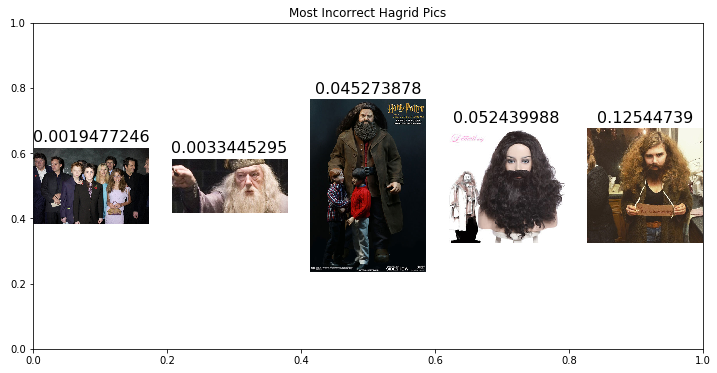

In [32]:
i = 3
num_inc = cm[i].sum()-cm[i][i]
plot_val_with_title(i, False, 'Most Incorrect '+ data.classes[i]+' Pics', num = num_inc)

In [33]:
real_mis_class = 8
1 - real_mis_class / cm.sum()

0.9578947368421052

Not counting images that are plain nonsense, or images that feature multiple people, we get an accuracy of 95.7%. Not bad!

## Individual Prediction

In [34]:
___, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset(['misc/self.jpg'], np.array([0]), val_tfms, '')
dl = DataLoader(ds)
log_p = learn.predict_dl(dl)
my_probs = np.mean(np.exp(log_p), 0)
my_probs

array([0.01044, 0.01281, 0.84582, 0.00089, 0.0319 , 0.00041, 0.02833, 0.02845, 0.03044, 0.0105 ],
      dtype=float32)

This a picture of me. Which HP character to I look like?

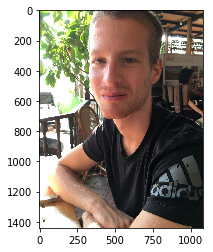

In [35]:
plt.imshow(plt.imread('misc/self.jpg'))

In [36]:
print('The most resembling character is ', data.classes[np.argsort(-my_probs)[0]].replace('_', ' ') +
     ' with probability ' + str(my_probs[np.argsort(-my_probs)[0]]))

The most resembling character is  Draco Malfoy with probability 0.8458218


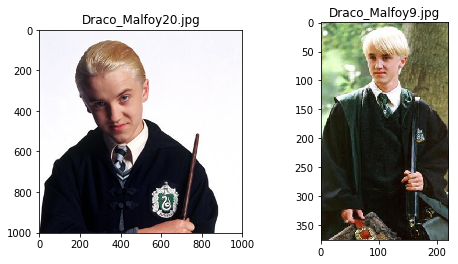

In [37]:
showPics(data.classes[np.argsort(-my_probs)[0]], dims=(1, 2))